In [24]:
from tqdm import tqdm
import torch
from torch import nn
import matplotlib.pyplot as plt

In [25]:
import itertools
import dm_env
from dm_env import specs
import numpy as np
from typing import Tuple


class Stimulus:
    def __init__(self, activation_length: int):
        self.active = False
        self.activation_length = activation_length
        self.onset = None
        self.activation_steps = 0

    def set_onset(self, onset):
        self.onset = onset

    def tick(self, time_step):
        if self.active:
            if self.activation_steps >= self.activation_length:
                self.active = False
                self.activation_steps = 0
            self.activation_steps += 1
        else:
            if self.onset == time_step:
                self.active = True
                self.activation_steps = 1

    def get_value(self):
        return int(self.active)


class TraceConditioning(dm_env.Environment):
    def __init__(self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float,
                 num_distractors: int, activation_lengths: dict):
        self.num_US = 1
        self.num_CS = 1

        self.ISI_interval = ISI_interval
        self.ITI_interval = ITI_interval
        self.gamma = gamma

        self.US = Stimulus(activation_lengths["US"])
        self.CS = Stimulus(activation_lengths["CS"])

        self.num_distractors = num_distractors
        self.distractors_probs = 1. / np.arange(10, 110, 10)
        self.distractors = [Stimulus(activation_lengths["distractor"]) for _ in range(self.num_distractors)]

        self.time_step = None
        self.trial_start = None
        self.rand_num_generator = np.random.RandomState(seed)

    def reset(self):
        self.time_step = 0
        self.trial_start = 0
        self.configure_trial()
        self.configure_distractors()
        self.tick()
        return dm_env.restart(self.observation())

    def step(self, _):
        self.time_step += 1
        if self.time_step == self.trial_start:
            self.configure_trial()
        self.configure_distractors()
        self.tick()
        return dm_env.TimeStep(dm_env.StepType.MID, self.cumulant(), self.gamma,
                               self.observation())

    def configure_trial(self):
        self.CS.set_onset(self.time_step)
        ISI = self.rand_num_generator.randint(self.ISI_interval[0], self.ISI_interval[1] + 1)
        self.US.set_onset(self.time_step + ISI)
        ITI = self.rand_num_generator.randint(self.ITI_interval[0], self.ITI_interval[1] + 1)
        self.trial_start = self.time_step + ISI + ITI

    def configure_distractors(self):
        for d, distractor in enumerate(self.distractors):
            if (not distractor.active) and self.rand_num_generator.rand() < self.distractors_probs[d]:
                distractor.set_onset(self.time_step)

    def tick(self):
        self.US.tick(self.time_step)
        self.CS.tick(self.time_step)
        for d, distractor in enumerate(self.distractors):
            distractor.tick(self.time_step)

    def cumulant(self):
        return self.US.get_value()

    def observation(self):
        observations = np.zeros(self.num_US + self.num_CS + self.num_distractors)
        observations[0] = self.US.get_value()
        observations[1] = self.CS.get_value()
        for d, distractor in enumerate(self.distractors):
            observations[d + self.num_US + self.num_CS] = distractor.get_value()
        return observations

    def observation_spec(self):
        return specs.BoundedArray(shape=(self.num_US + self.num_CS + self.num_distractors),
                                  dtype=np.float32,
                                  name="observation",
                                  minimum=0,
                                  maximum=1)

    def action_spec(self):
        return specs.DiscreteArray(
            dtype=int, num_values=0, name="action")


class TracePatterning(dm_env.Environment):
    def __init__(
            self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float, num_CS: int,
            num_activation_patterns: int, activation_patterns_prob: float, num_distractors: int,
            activation_lengths: dict, noise: float):

        self.num_US = 1
        self.US = Stimulus(activation_lengths["US"])

        self.num_CS = num_CS
        self.CSs = [Stimulus(activation_lengths["CS"]) for _ in range(self.num_CS)]

        self.num_distractors = num_distractors
        self.distractors = [Stimulus(activation_lengths["distractor"]) for _ in range(self.num_distractors)]

        self.num_activation_patterns = num_activation_patterns
        self.activation_patterns_prob = activation_patterns_prob
        self.rand_num_generator = np.random.RandomState(seed)
        self.activation_patterns = produce_activation_patterns(self.rand_num_generator, self.num_CS,
                                                               self.num_activation_patterns)
        self.p = ((2 ** self.num_CS) * self.activation_patterns_prob - self.num_activation_patterns) / \
                 (2 ** self.num_CS - self.num_activation_patterns)

        self.ISI_interval = ISI_interval
        self.ITI_interval = ITI_interval
        self.gamma = gamma
        self.noise = noise

        self.time_step = None
        self.trial_start = None

    def reset(self):
        self.trial_start = 0
        self.time_step = 0
        self.configure_trial()
        self.tick()
        return dm_env.restart(self.observation())

    def step(self, _):
        self.time_step += 1
        if self.time_step == self.trial_start:
            self.configure_trial()
        self.tick()
        return dm_env.TimeStep(dm_env.StepType.MID, self.cumulant(), self.gamma,
                               self.observation())

    def configure_trial(self):
        CS_pattern = self.set_CSs()
        ISI = self.rand_num_generator.randint(self.ISI_interval[0], self.ISI_interval[1] + 1)
        self.set_US(ISI, CS_pattern)
        self.set_distractors()
        ITI = self.rand_num_generator.randint(self.ITI_interval[0], self.ITI_interval[1] + 1)
        self.trial_start = self.time_step + ISI + ITI

    def set_CSs(self):
        if self.rand_num_generator.rand() < self.p:
            CS_pattern = self.activation_patterns[self.rand_num_generator.choice(self.num_activation_patterns), :]
        else:
            CS_pattern = np.ndarray.astype((self.rand_num_generator.randint(2, size=self.num_CS)), dtype=float)
        for c, CS in enumerate(self.CSs):
            if CS_pattern[c] == 1:
                CS.set_onset(self.time_step)
        return CS_pattern

    def set_US(self, ISI, CS_pattern):
        if np.sum(binary_match(CS_pattern, self.activation_patterns)) > 0:
            if self.rand_num_generator.rand() > self.noise:
                self.US.set_onset(self.time_step + ISI)
        else:
            if self.rand_num_generator.rand() < self.noise:
                self.US.set_onset(self.time_step + ISI)

    def set_distractors(self):
        distractor_pattern = np.ndarray.astype((self.rand_num_generator.randint(2, size=self.num_distractors)),
                                               dtype=float)
        for d, distractor in enumerate(self.distractors):
            if distractor_pattern[d]:
                distractor.set_onset(self.time_step)

    def tick(self):
        for c, CS in enumerate(self.CSs):
            CS.tick(self.time_step)
        self.US.tick(self.time_step)
        for d, distractor in enumerate(self.distractors):
            distractor.tick(self.time_step)

    def cumulant(self):
        return self.US.get_value()

    def observation(self):
        observations = np.zeros(self.num_US + self.num_CS + self.num_distractors)
        observations[0] = self.US.get_value()
        for c, CS in enumerate(self.CSs):
            observations[c + 1] = CS.get_value()
        for d, distractor in enumerate(self.distractors):
            observations[d + self.num_CS + self.num_US] = distractor.get_value()
        return observations

    def observation_spec(self):
        return specs.BoundedArray(shape=(self.num_US + self.num_CS + self.num_distractors),
                                  dtype=np.float32,
                                  name="observation",
                                  minimum=0,
                                  maximum=1)

    def action_spec(self):
        return specs.DiscreteArray(
            dtype=int, num_values=0, name="action")


class NoisyPatterning(TracePatterning):
    def __init__(
            self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float, num_CS: int,
            num_activation_patterns: int, activation_patterns_prob: float, num_distractors: int,
            activation_lengths: dict, noise: float):
        super().__init__(seed, ISI_interval, ITI_interval, gamma, num_CS, num_activation_patterns,
                         activation_patterns_prob, num_distractors, activation_lengths, noise)
        self.ISI_interval = (activation_lengths["CS"], activation_lengths["CS"])


def compute_return_error(cumulants, predictions, gamma):
    num_time_steps = len(cumulants)
    returns = np.zeros(num_time_steps)
    returns[-1] = cumulants[-1]
    for t in range(num_time_steps - 2, -1, -1):
        returns[t] = gamma * returns[t + 1] + cumulants[t]
    return_error = (predictions - returns) ** 2
    MSRE = return_error.mean()
    return MSRE, return_error, returns


def produce_activation_patterns(rand_num_generator, num_CS, num_activation_patterns):
    activated_indices = list(itertools.combinations(np.arange(num_CS), int(num_CS / 2)))
    selected_indices = rand_num_generator.choice(np.arange(len(activated_indices)), size=num_activation_patterns,
                                                 replace=False)
    activation_patterns = np.zeros((num_activation_patterns, num_CS))
    for i in range(num_activation_patterns):
        activation_patterns[i, activated_indices[selected_indices[i]]] = 1.0
    return activation_patterns


def binary_match(x, patterns):
    if sum(x) == 0:
        ones_match = np.ones(patterns.shape[0])
    else:
        ones_match = np.floor(np.dot(patterns, x) / sum(x))
    if sum(1 - x) == 0:
        zeros_match = np.ones(patterns.shape[0])
    else:
        zeros_match = np.floor(np.dot(1 - patterns, 1 - x) / sum(1 - x))
    return ones_match * zeros_match


In [26]:
cfg = {
    'NUM_CS' : 1,
    'NUM_US' : 1,
    'NUM_DIST' : 10,
    'ISI_interval' : (7,13),
    'ITI_interval' : (80,120),
    'LEN_CS' : 4,
    'LEN_US' : 2,
    'LEN_DIST' : 4,
    'ADAMB1' : 0.9,
    'ADAMB2' : 0.999,
    'ADAME' : 10e-8,
    'LAMBDA' : 0,
    'N_TRAIN_STEPS' : 100000,
    'TBPTT_T' : 10,
    'HIDDEN_L_SIZE' : 10,
    'STEP_SIZE' : 1e-4,
    'INITIAL_STEPS': 100,
}
cfg['GAMMA'] = 1-1/np.mean(cfg['ISI_interval'])

In [44]:
def plot_last_n(obsall, predall, errors=None, n=1000):
    nobs = cfg['NUM_CS'] + cfg['NUM_US'] + cfg['NUM_DIST']

    fig, axs = plt.subplots(5,figsize=(30, 35))
    fig.tight_layout()
    for i in range(2):
        axs[i].step(list(range(n)), obsall[:, i][-n:])

    if errors is not None:
        axs[-3].step(list(range(n)), errors[2][-n:] )
        axs[-2].step(list(range(n)), predall[-n:] )
        axs[-1].step(list(range(n)), errors[1][-n:])
        print(f'MSE: {errors[0]}')

    axs[0].title.set_text('US')
    axs[1].title.set_text('CS')
    axs[-3].title.set_text('return target')
    axs[-2].title.set_text('return prediction')
    axs[-1].title.set_text('return error')
    for ax in axs:
        ax.grid(color='#666666', linestyle='-', alpha=0.5)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
class LSTM_V(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = cfg['NUM_CS'] + cfg['NUM_US'] + cfg['NUM_DIST'],
                            hidden_size = cfg['HIDDEN_L_SIZE'],
                            num_layers = 1,
                            dropout = 0)
        self.linear = nn.Linear(cfg['HIDDEN_L_SIZE'], 1)
        self.hidden = (torch.randn(1, 1, cfg['HIDDEN_L_SIZE']).to(device),
                       torch.randn(1, 1, cfg['HIDDEN_L_SIZE']).to(device))
        self.hidden_0 = self.hidden # used to save (h_0, c_0) of last batch
        
    def reset_hidden(self):
        self.hidden = (torch.randn(1, 1, cfg['HIDDEN_L_SIZE']).to(device),
                       torch.randn(1, 1, cfg['HIDDEN_L_SIZE']).to(device)) 
        
    def forward(self, obs):
        obs = obs.view(len(obs), 1, -1)
        lstm_out_0, self.hidden = self.lstm(obs[0].view(1,1,-1), self.hidden_0)
        
        # save the hidden state (h_0 and c_0) of first element for when the LSTM is called
        # so that it can be used when a new batch is passed in
        self.hidden_0 = (self.hidden[0].detach(), self.hidden[1].detach())

        lstm_out, self.hidden = self.lstm(obs[1:], self.hidden)
        lstm_out = torch.cat((lstm_out_0, lstm_out))
        
        # hidden_size -> 1 for each obs
        values = self.linear(lstm_out.view(len(obs), -1))
        return values

In [30]:
tc = TraceConditioning(seed=2,
                       ISI_interval=cfg['ISI_interval'],
                       ITI_interval=cfg['ITI_interval'],
                       gamma=cfg['GAMMA'],
                       num_distractors=cfg['NUM_DIST'],
                       activation_lengths={'CS': cfg['LEN_CS'], 'US': cfg['LEN_US'], 'distractor':cfg['LEN_DIST']})

In [31]:
model = LSTM_V().to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=cfg['STEP_SIZE'],
                             betas=[cfg['ADAMB1'], 
                                    cfg['ADAMB2']], 
                             eps=cfg['ADAME'])


In [32]:
def train_td(env, model, loss, optimizer):
    state = env.reset()
    obsall = np.zeros((cfg['N_TRAIN_STEPS'], state.observation.shape[0],))
    predall = np.zeros((cfg['N_TRAIN_STEPS']))
    t = -1
    # take 100 steps at start
    for i in range(cfg['INITIAL_STEPS']):
        t += 1
        step = env.step(_)
        obsall[t] = step.observation
        predall[t] = 0

    for i in tqdm(range(cfg['N_TRAIN_STEPS'] - cfg['INITIAL_STEPS'])):
        t += 1
        step_new = env.step(_)
        obsall[t] = step_new.observation

        # get V_t-T .... V_t.
        V_t = model(torch.FloatTensor(obsall[t-cfg['TBPTT_T']: t+1]).to(device))

        # get the next step prediction (V_t+1) for each step (V_t)
        V_tp1 = V_t[1:]
        # get the reward obtained (US_t+1) for going to next step
        US_tp1 = torch.tensor(
            obsall[t-cfg['TBPTT_T']+1: t+1][:,0]
        ).view(-1,1).to(device)

        # dont use gradient when calculating the TD target
        # For each value prediction V_t at step t, we use US_t+1 and V_t+1 to calculate TD target
        with torch.no_grad():
            td_target = US_tp1 + cfg['GAMMA'] * V_tp1

        # V_t also includes the prediction for o_t, so we remove it from here.
        # It is only used to calculate the TD target for o_t-1 previously
        td_error = loss(V_t[:-1], td_target.float())
        td_error.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 1000 == 0:
            print(f'TD Error at t:{i} = {td_error}')

        # Store the value prediction belonging to o_t
        predall[t] = V_tp1[-1].detach().item()
        
    return obsall, predall

In [33]:
obsall, predall = train_td(tc, model, loss, optimizer)
errors = compute_return_error(obsall[:,0], predall, cfg['GAMMA'])

  0%|          | 65/99900 [00:00<02:34, 645.35it/s]

TD Error at t:0 = 0.00041914041503332555


  1%|          | 1077/99900 [00:01<02:28, 664.69it/s]

TD Error at t:1000 = 0.22009046375751495


  2%|▏         | 2077/99900 [00:03<02:34, 635.17it/s]

TD Error at t:2000 = 0.0003049762162845582


  3%|▎         | 3065/99900 [00:04<02:38, 611.29it/s]

TD Error at t:3000 = 0.0006604496156796813


  4%|▍         | 4076/99900 [00:06<02:22, 672.09it/s]

TD Error at t:4000 = 0.0002926556917373091


  5%|▌         | 5097/99900 [00:07<02:22, 665.46it/s]

TD Error at t:5000 = 0.0004560197703540325


  6%|▌         | 6117/99900 [00:09<02:19, 670.03it/s]

TD Error at t:6000 = 0.0012496598064899445


  7%|▋         | 7068/99900 [00:10<02:19, 667.22it/s]

TD Error at t:7000 = 0.0005100095295347273


  8%|▊         | 8082/99900 [00:12<02:20, 653.56it/s]

TD Error at t:8000 = 0.0015285690315067768


  9%|▉         | 9094/99900 [00:13<02:17, 661.83it/s]

TD Error at t:9000 = 0.001173193333670497


 10%|█         | 10114/99900 [00:15<02:12, 678.98it/s]

TD Error at t:10000 = 0.0013608497101813555


 11%|█         | 11068/99900 [00:16<02:12, 668.94it/s]

TD Error at t:11000 = 0.0016112899174913764


 12%|█▏        | 12083/99900 [00:18<02:11, 666.41it/s]

TD Error at t:12000 = 0.0034390129148960114


 13%|█▎        | 13095/99900 [00:19<02:10, 665.16it/s]

TD Error at t:13000 = 0.0002638104488141835


 14%|█▍        | 14128/99900 [00:21<02:08, 668.88it/s]

TD Error at t:14000 = 0.006050989031791687


 15%|█▌        | 15078/99900 [00:22<02:07, 666.69it/s]

TD Error at t:15000 = 0.0013796311104670167


 16%|█▌        | 16090/99900 [00:24<02:06, 665.13it/s]

TD Error at t:16000 = 0.00014813552843406796


 17%|█▋        | 17089/99900 [00:25<02:07, 648.26it/s]

TD Error at t:17000 = 0.001329608610831201


 18%|█▊        | 18085/99900 [00:27<02:03, 660.90it/s]

TD Error at t:18000 = 0.00022535529569722712


 19%|█▉        | 19090/99900 [00:28<02:07, 634.32it/s]

TD Error at t:19000 = 0.00030608693487010896


 20%|██        | 20134/99900 [00:30<01:59, 666.47it/s]

TD Error at t:20000 = 0.000884411099832505


 21%|██        | 21089/99900 [00:31<01:56, 677.24it/s]

TD Error at t:21000 = 0.0008860441157594323


 22%|██▏       | 22071/99900 [00:33<01:58, 657.02it/s]

TD Error at t:22000 = 0.0004685113381128758


 23%|██▎       | 23083/99900 [00:34<01:54, 671.34it/s]

TD Error at t:23000 = 0.18033698201179504


 24%|██▍       | 24101/99900 [00:36<01:55, 653.78it/s]

TD Error at t:24000 = 0.00011444091796875


 25%|██▌       | 25091/99900 [00:38<01:51, 671.46it/s]

TD Error at t:25000 = 0.0010482053039595485


 26%|██▌       | 26119/99900 [00:39<01:47, 687.63it/s]

TD Error at t:26000 = 0.0005101061542518437


 27%|██▋       | 27069/99900 [00:40<01:49, 667.79it/s]

TD Error at t:27000 = 0.0013588509755209088


 28%|██▊       | 28075/99900 [00:42<01:48, 659.32it/s]

TD Error at t:28000 = 0.00023789754777681082


 29%|██▉       | 29081/99900 [00:44<01:47, 656.57it/s]

TD Error at t:29000 = 0.0005446763825602829


 30%|███       | 30089/99900 [00:45<01:44, 669.01it/s]

TD Error at t:30000 = 0.03220123425126076


 31%|███       | 31101/99900 [00:47<01:44, 657.62it/s]

TD Error at t:31000 = 0.000232787846471183


 32%|███▏      | 32086/99900 [00:48<01:46, 639.65it/s]

TD Error at t:32000 = 0.0005100801936350763


 33%|███▎      | 33079/99900 [00:50<01:39, 668.22it/s]

TD Error at t:33000 = 0.0002982652513310313


 34%|███▍      | 34092/99900 [00:51<01:37, 674.26it/s]

TD Error at t:34000 = 0.00038696188130415976


 35%|███▌      | 35108/99900 [00:53<01:37, 666.53it/s]

TD Error at t:35000 = 0.0003618828486651182


 36%|███▌      | 36119/99900 [00:54<01:36, 664.03it/s]

TD Error at t:36000 = 0.028839487582445145


 37%|███▋      | 37133/99900 [00:56<01:33, 668.23it/s]

TD Error at t:37000 = 0.00011113870277768001


 38%|███▊      | 38069/99900 [00:57<01:35, 645.90it/s]

TD Error at t:38000 = 0.0003579900658223778


 39%|███▉      | 39075/99900 [00:59<01:32, 661.10it/s]

TD Error at t:39000 = 0.00012581665941979736


 40%|████      | 40074/99900 [01:00<01:31, 656.21it/s]

TD Error at t:40000 = 0.00028617485077120364


 41%|████      | 41084/99900 [01:02<01:28, 666.22it/s]

TD Error at t:41000 = 6.85203995089978e-05


 42%|████▏     | 42096/99900 [01:03<01:27, 663.02it/s]

TD Error at t:42000 = 0.026395324617624283


 43%|████▎     | 43117/99900 [01:05<01:25, 667.57it/s]

TD Error at t:43000 = 0.023293694481253624


 44%|████▍     | 44068/99900 [01:06<01:23, 669.40it/s]

TD Error at t:44000 = 7.26604848750867e-05


 45%|████▌     | 45077/99900 [01:08<01:22, 663.44it/s]

TD Error at t:45000 = 0.00010974745964631438


 46%|████▌     | 46095/99900 [01:09<01:20, 670.62it/s]

TD Error at t:46000 = 4.013978104921989e-05


 47%|████▋     | 47108/99900 [01:11<01:18, 670.05it/s]

TD Error at t:47000 = 0.00011972752690780908


 48%|████▊     | 48123/99900 [01:12<01:17, 668.94it/s]

TD Error at t:48000 = 0.00016774759569671005


 49%|████▉     | 49069/99900 [01:14<01:16, 663.30it/s]

TD Error at t:49000 = 0.00010054633457912132


 50%|█████     | 50083/99900 [01:15<01:14, 669.18it/s]

TD Error at t:50000 = 7.680594717385247e-05


 51%|█████     | 51094/99900 [01:17<01:13, 667.54it/s]

TD Error at t:51000 = 0.00026562652783468366


 52%|█████▏    | 52107/99900 [01:18<01:10, 675.43it/s]

TD Error at t:52000 = 8.742661884753034e-05


 53%|█████▎    | 53129/99900 [01:20<01:09, 673.69it/s]

TD Error at t:53000 = 0.00010805097554111853


 54%|█████▍    | 54070/99900 [01:21<01:08, 667.71it/s]

TD Error at t:54000 = 0.00014843852841295302


 55%|█████▌    | 55082/99900 [01:23<01:06, 669.20it/s]

TD Error at t:55000 = 0.00011181648733327165


 56%|█████▌    | 56103/99900 [01:24<01:05, 671.37it/s]

TD Error at t:56000 = 8.52933808346279e-05


 57%|█████▋    | 57119/99900 [01:26<01:03, 669.06it/s]

TD Error at t:57000 = 0.0003339496615808457


 58%|█████▊    | 58073/99900 [01:27<01:01, 682.54it/s]

TD Error at t:58000 = 0.008341514505445957


 59%|█████▉    | 59080/99900 [01:29<01:05, 621.58it/s]

TD Error at t:59000 = 6.25973116257228e-05


 60%|██████    | 60086/99900 [01:30<00:59, 665.29it/s]

TD Error at t:60000 = 0.00015714096662122756


 61%|██████    | 61105/99900 [01:32<01:00, 640.66it/s]

TD Error at t:61000 = 7.092460873536766e-05


 62%|██████▏   | 62117/99900 [01:33<00:55, 676.97it/s]

TD Error at t:62000 = 9.131445403909311e-05


 63%|██████▎   | 63129/99900 [01:35<00:55, 665.97it/s]

TD Error at t:63000 = 0.00035511990427039564


 64%|██████▍   | 64071/99900 [01:36<00:53, 666.96it/s]

TD Error at t:64000 = 0.00013995806511957198


 65%|██████▌   | 65083/99900 [01:38<00:52, 663.80it/s]

TD Error at t:65000 = 0.00018936675041913986


 66%|██████▌   | 66093/99900 [01:39<00:50, 671.84it/s]

TD Error at t:66000 = 0.00010655837832018733


 67%|██████▋   | 67098/99900 [01:41<00:49, 659.45it/s]

TD Error at t:67000 = 0.0386107936501503


 68%|██████▊   | 68113/99900 [01:42<00:47, 674.16it/s]

TD Error at t:68000 = 0.0001572550245327875


 69%|██████▉   | 69128/99900 [01:44<00:46, 660.54it/s]

TD Error at t:69000 = 4.470050407689996e-05


 70%|███████   | 70069/99900 [01:45<00:47, 629.99it/s]

TD Error at t:70000 = 0.00044072186574339867


 71%|███████   | 71077/99900 [01:47<00:43, 667.76it/s]

TD Error at t:71000 = 0.00010732799273682758


 72%|███████▏  | 72099/99900 [01:48<00:40, 680.28it/s]

TD Error at t:72000 = 0.01610756851732731


 73%|███████▎  | 73105/99900 [01:50<00:43, 609.37it/s]

TD Error at t:73000 = 9.247526031685993e-05


 74%|███████▍  | 74093/99900 [01:51<00:39, 648.47it/s]

TD Error at t:74000 = 0.0002354870521230623


 75%|███████▌  | 75118/99900 [01:53<00:37, 653.77it/s]

TD Error at t:75000 = 6.16723918938078e-05


 76%|███████▌  | 76112/99900 [01:55<00:36, 655.06it/s]

TD Error at t:76000 = 0.00013365795894060284


 77%|███████▋  | 77124/99900 [01:56<00:34, 663.45it/s]

TD Error at t:77000 = 0.04057936742901802


 78%|███████▊  | 78068/99900 [01:58<00:35, 610.05it/s]

TD Error at t:78000 = 0.00015363996499218047


 79%|███████▉  | 79070/99900 [01:59<00:31, 659.14it/s]

TD Error at t:79000 = 7.563313556602225e-05


 80%|████████  | 80072/99900 [02:01<00:30, 654.58it/s]

TD Error at t:80000 = 0.042673658579587936


 81%|████████  | 81128/99900 [02:02<00:28, 649.50it/s]

TD Error at t:81000 = 0.00022467158851213753


 82%|████████▏ | 82083/99900 [02:04<00:26, 673.45it/s]

TD Error at t:82000 = 6.534865678986534e-05


 83%|████████▎ | 83095/99900 [02:05<00:25, 664.00it/s]

TD Error at t:83000 = 0.00010995378397637978


 84%|████████▍ | 84122/99900 [02:07<00:23, 669.87it/s]

TD Error at t:84000 = 0.00029251808882690966


 85%|████████▌ | 85122/99900 [02:08<00:23, 624.44it/s]

TD Error at t:85000 = 0.00028272156487219036


 86%|████████▌ | 86129/99900 [02:10<00:20, 666.72it/s]

TD Error at t:86000 = 8.601441368227825e-05


 87%|████████▋ | 87076/99900 [02:11<00:19, 650.89it/s]

TD Error at t:87000 = 0.00013412228145170957


 88%|████████▊ | 88078/99900 [02:13<00:18, 627.61it/s]

TD Error at t:88000 = 0.00014589722559321672


 89%|████████▉ | 89121/99900 [02:14<00:16, 641.63it/s]

TD Error at t:89000 = 0.00014536151138599962


 90%|█████████ | 90111/99900 [02:16<00:15, 625.65it/s]

TD Error at t:90000 = 0.038954541087150574


 91%|█████████ | 91077/99900 [02:18<00:14, 604.36it/s]

TD Error at t:91000 = 0.00014682782057207078


 92%|█████████▏| 92079/99900 [02:19<00:11, 659.57it/s]

TD Error at t:92000 = 0.00017959368415176868


 93%|█████████▎| 93086/99900 [02:21<00:10, 661.63it/s]

TD Error at t:93000 = 7.48856327845715e-05


 94%|█████████▍| 94102/99900 [02:22<00:08, 659.43it/s]

TD Error at t:94000 = 5.746824899688363e-05


 95%|█████████▌| 95112/99900 [02:24<00:07, 628.41it/s]

TD Error at t:95000 = 0.0001364280906273052


 96%|█████████▌| 96114/99900 [02:25<00:05, 652.36it/s]

TD Error at t:96000 = 0.00014924425340723246


 97%|█████████▋| 97109/99900 [02:27<00:04, 667.19it/s]

TD Error at t:97000 = 0.03197505325078964


 98%|█████████▊| 98118/99900 [02:28<00:02, 667.88it/s]

TD Error at t:98000 = 8.856981730787084e-05


 99%|█████████▉| 99072/99900 [02:30<00:01, 671.23it/s]

TD Error at t:99000 = 0.012066788040101528


100%|██████████| 99900/99900 [02:31<00:00, 659.55it/s]


In [70]:
a = np.arange(5)
np.roll(a, 1), np.insert(a, 0, 0)[:-1]

(array([4, 0, 1, 2, 3]), array([0, 0, 1, 2, 3]))

MSE: 0.04867291119248479


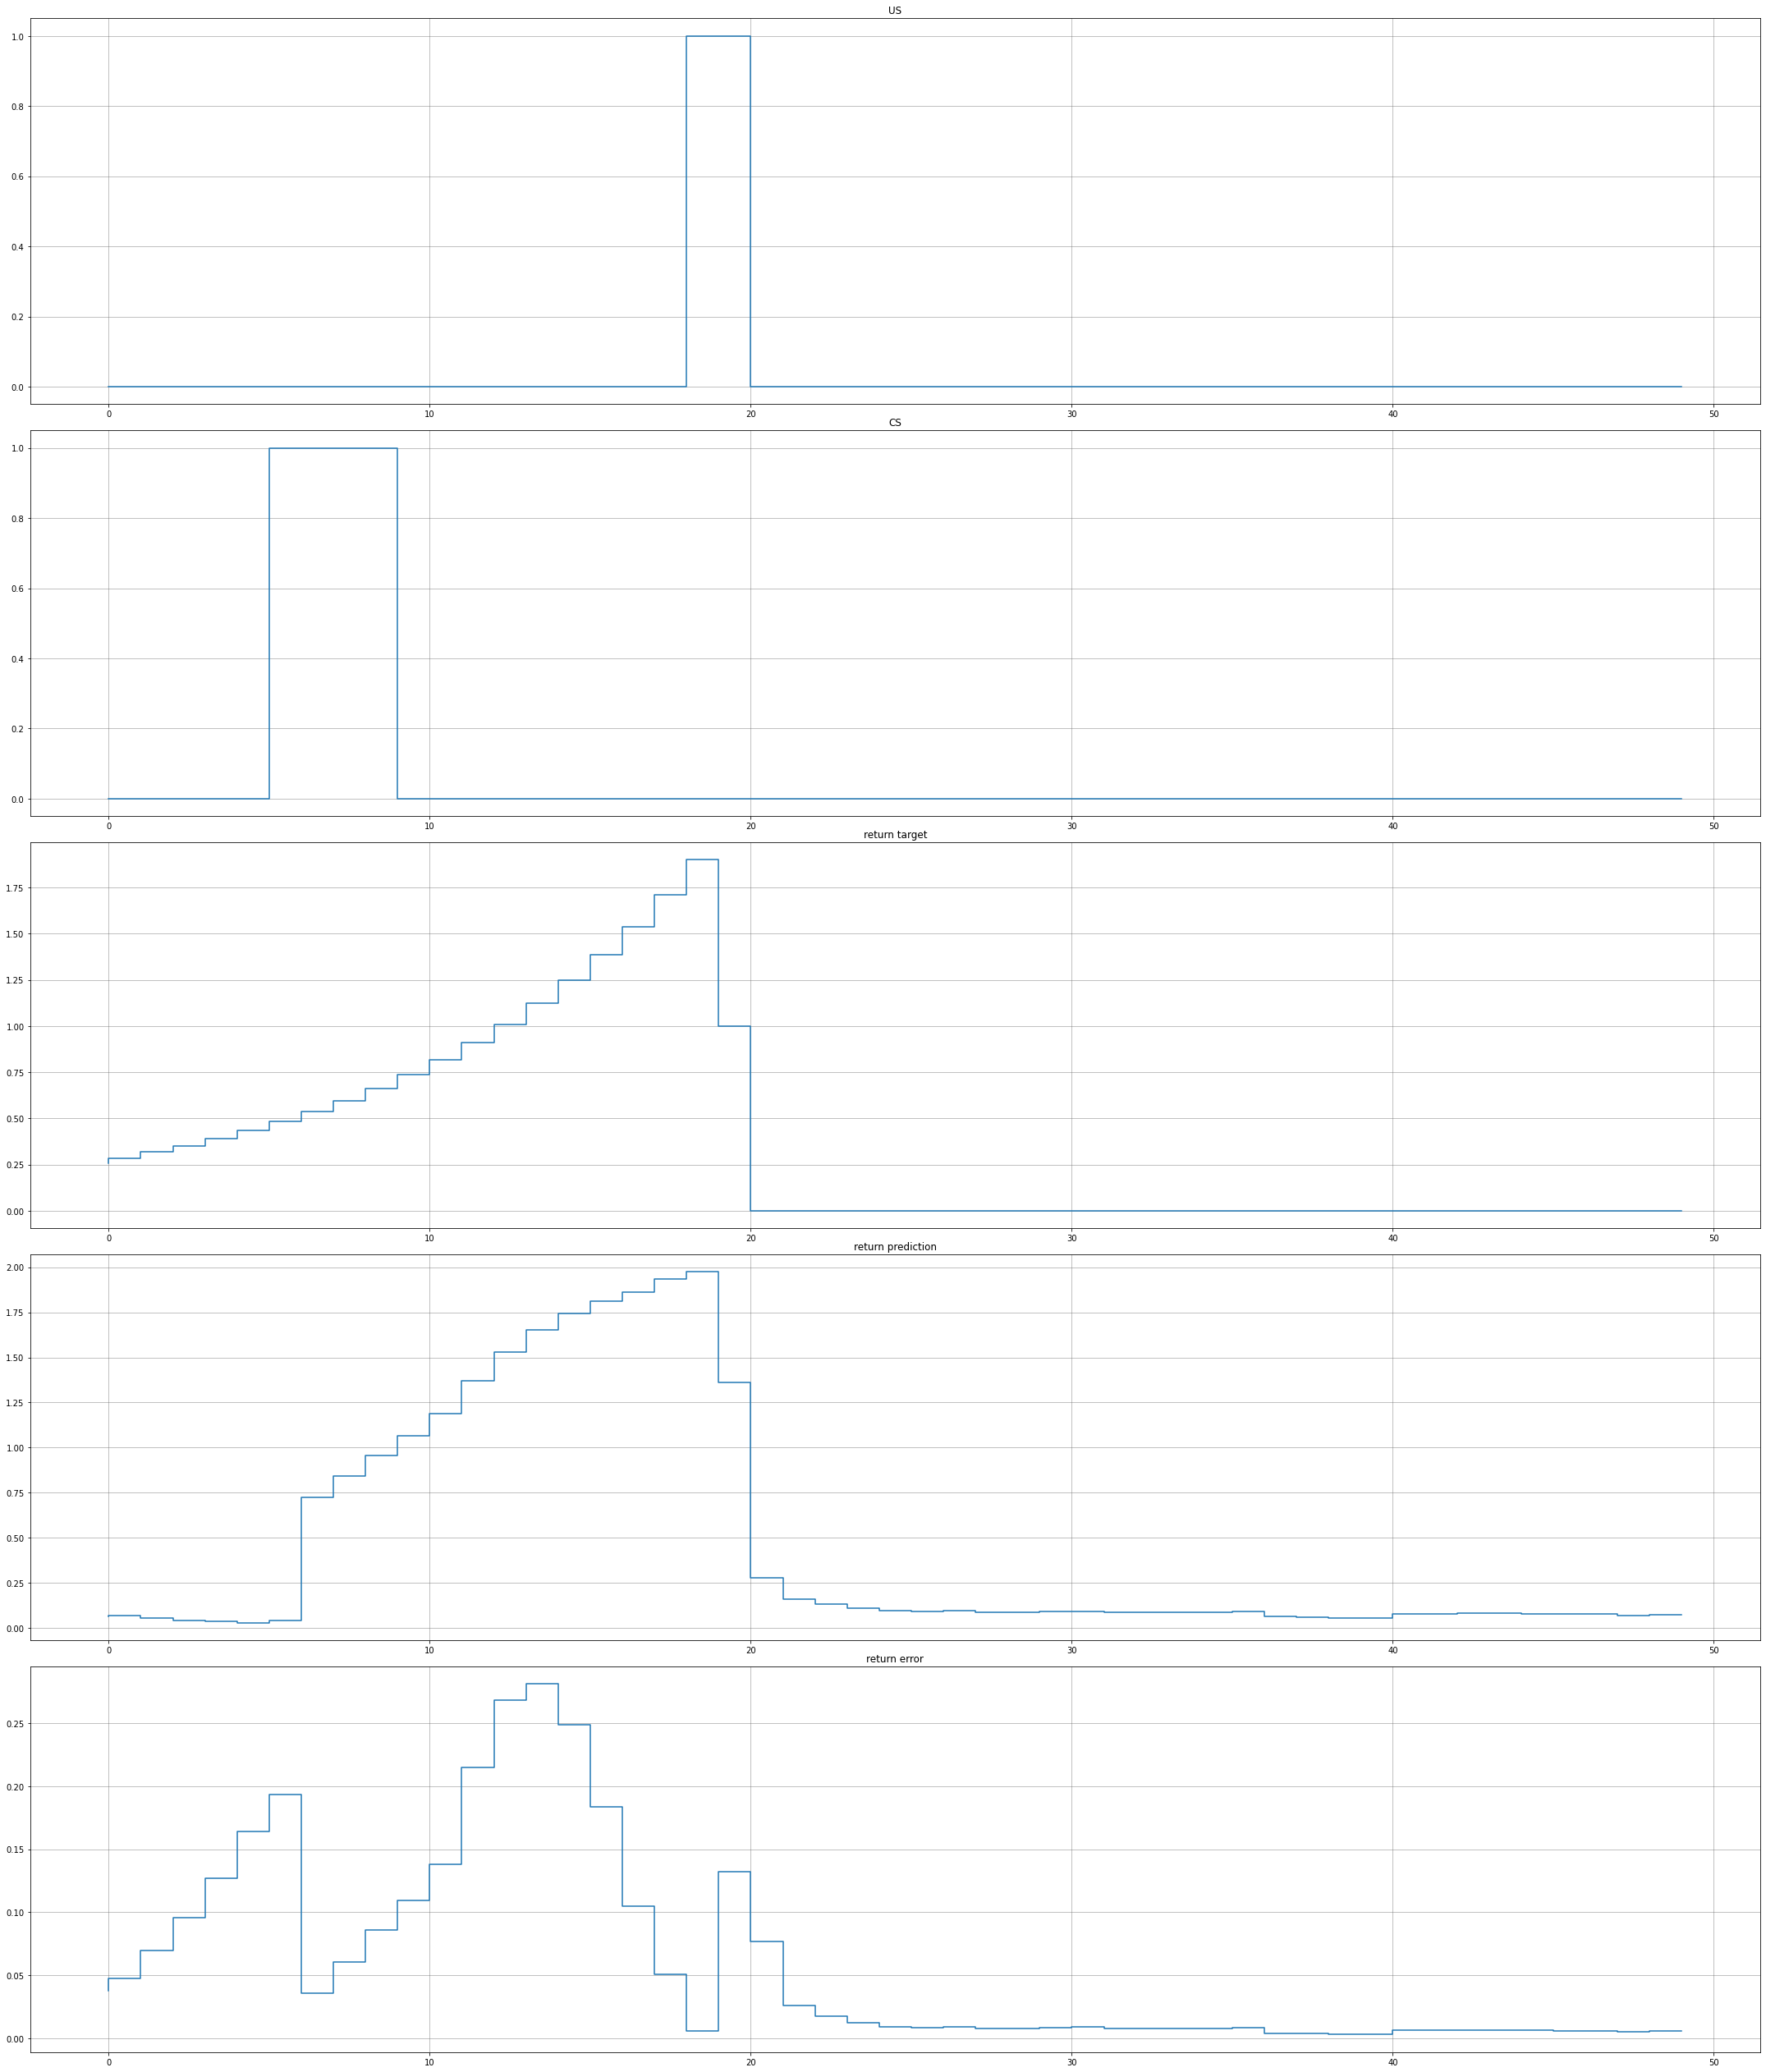

In [71]:
errors = compute_return_error(obsall[:,0], np.insert(predall, 0, 0)[:-1], cfg['GAMMA'])
plot_last_n(obsall, np.insert(predall, 0, 0)[:-1], errors, n=50)

MSE: 0.04867144316449277


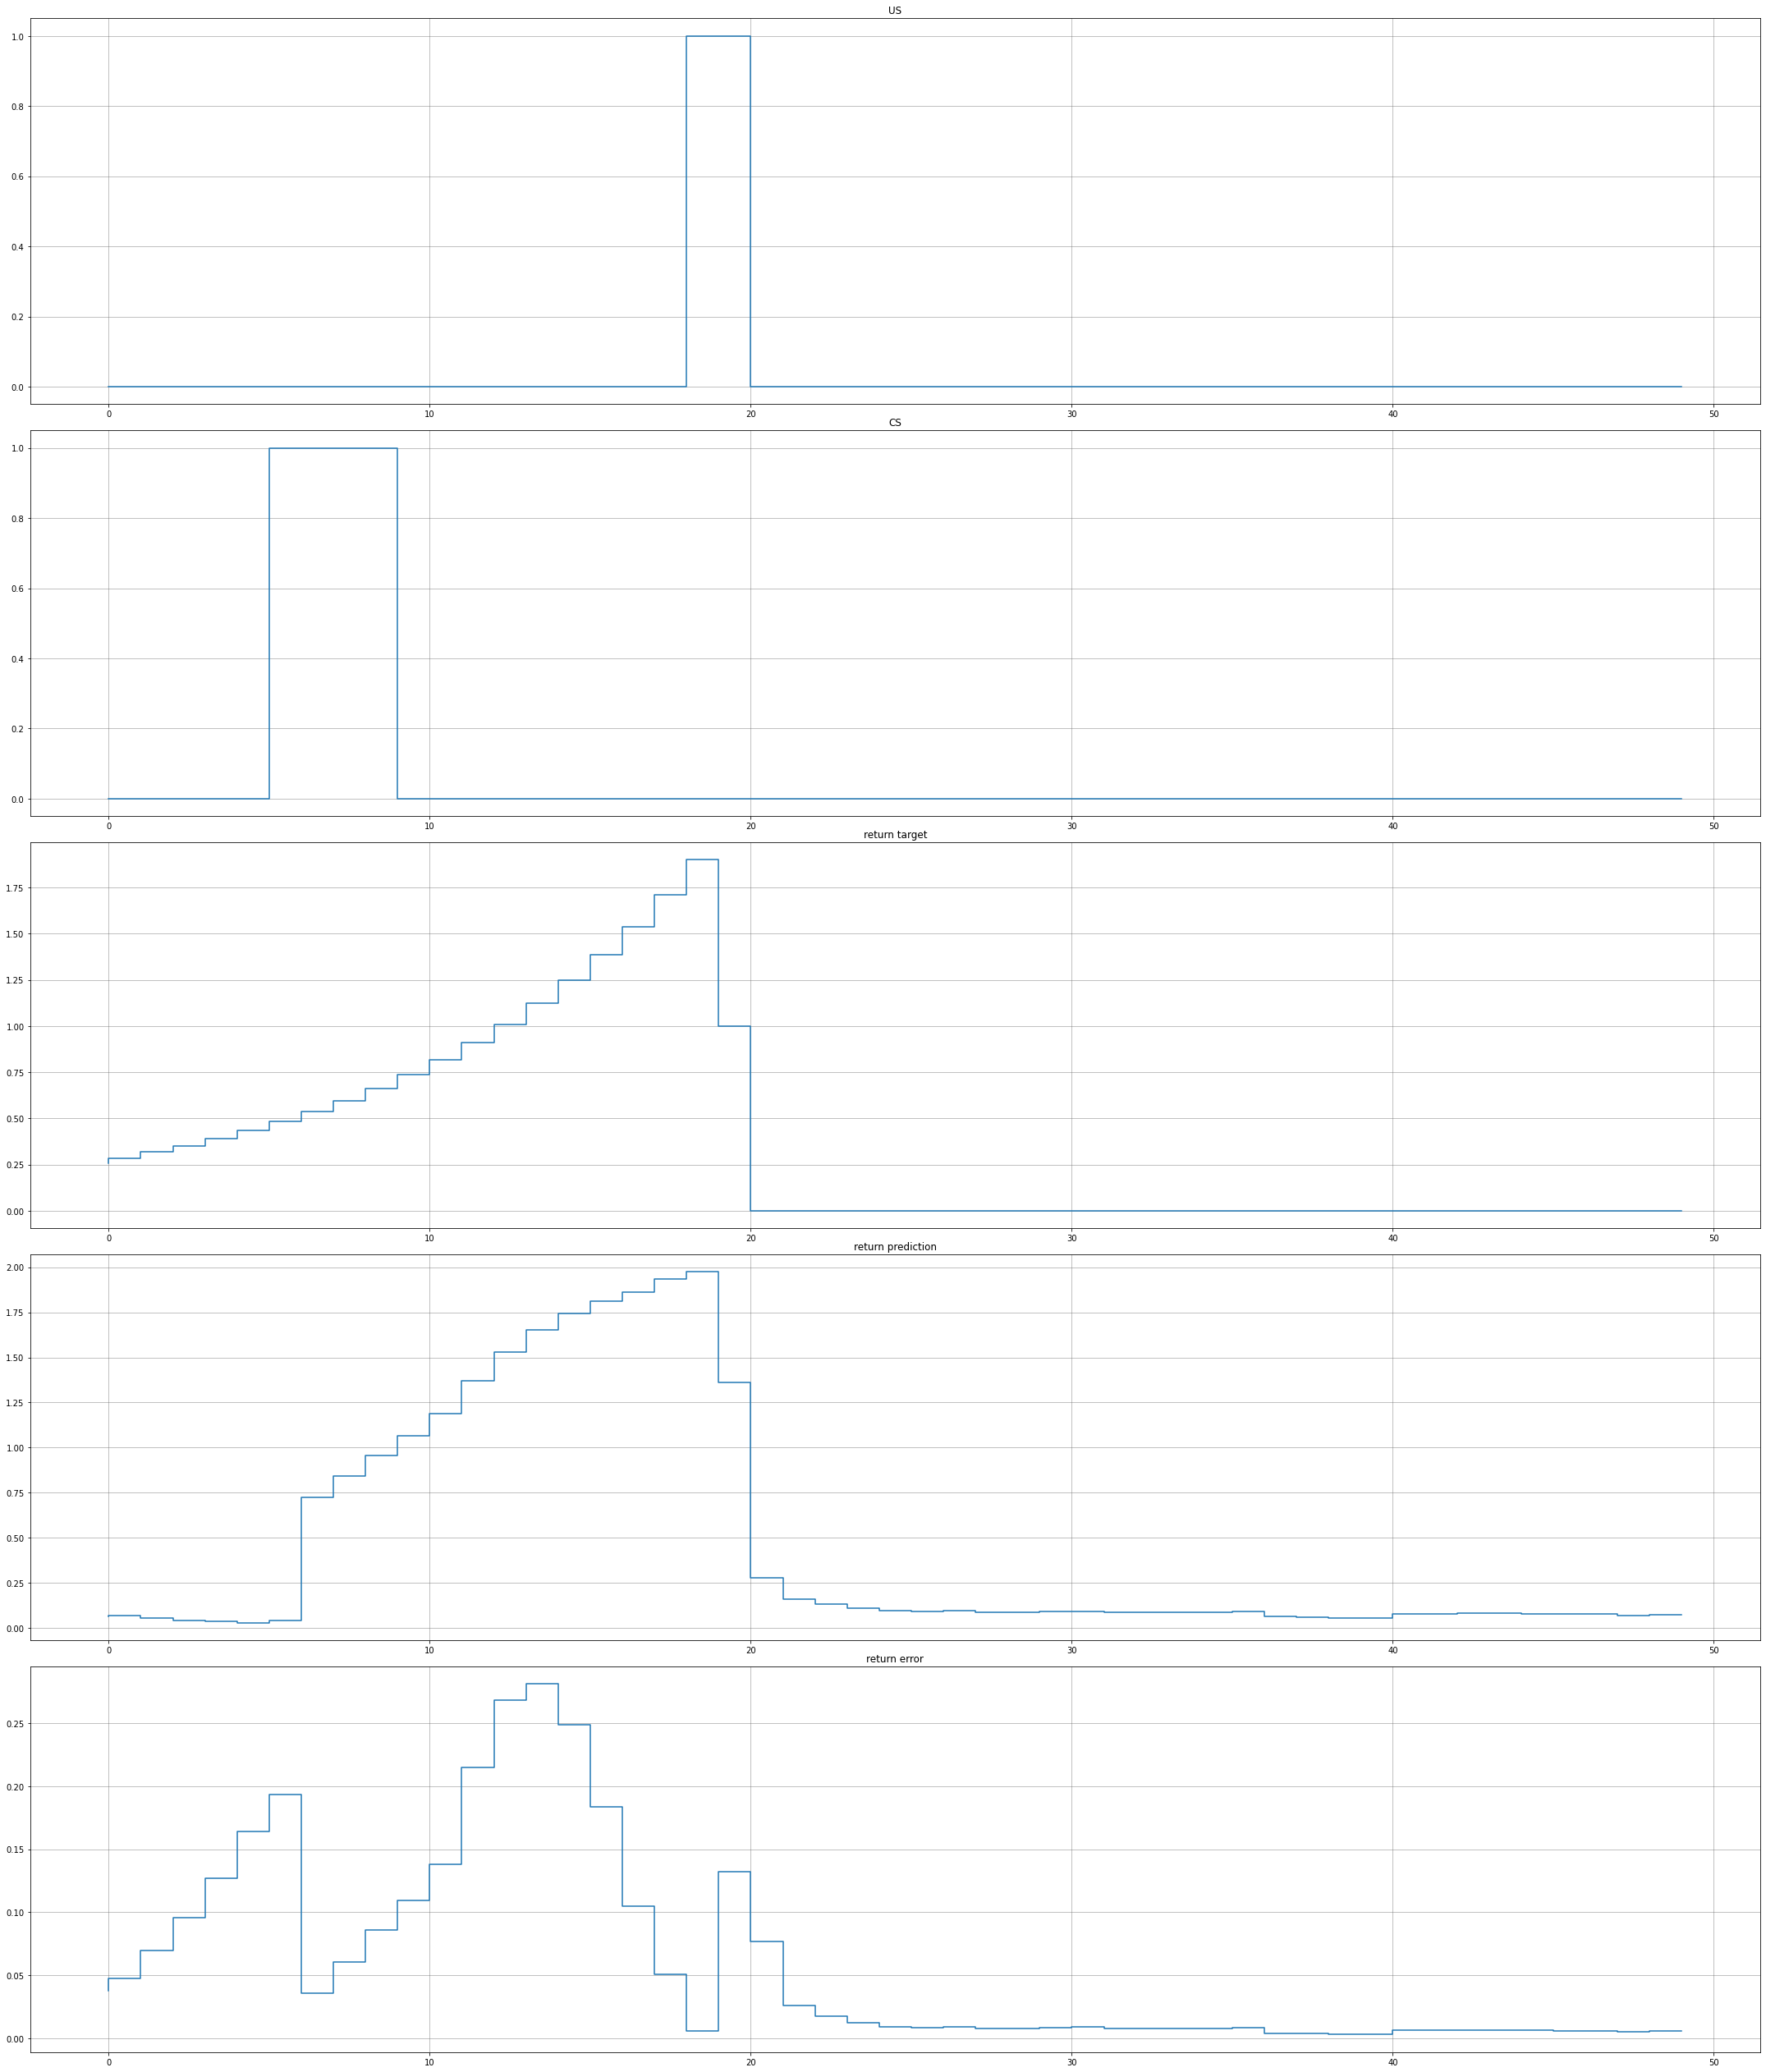

In [63]:
errors = compute_return_error(obsall[:,0], np.roll(predall,1), cfg['GAMMA'])
plot_last_n(obsall, np.roll(predall,1), errors, n=50)

MSE: 0.0538625480078908


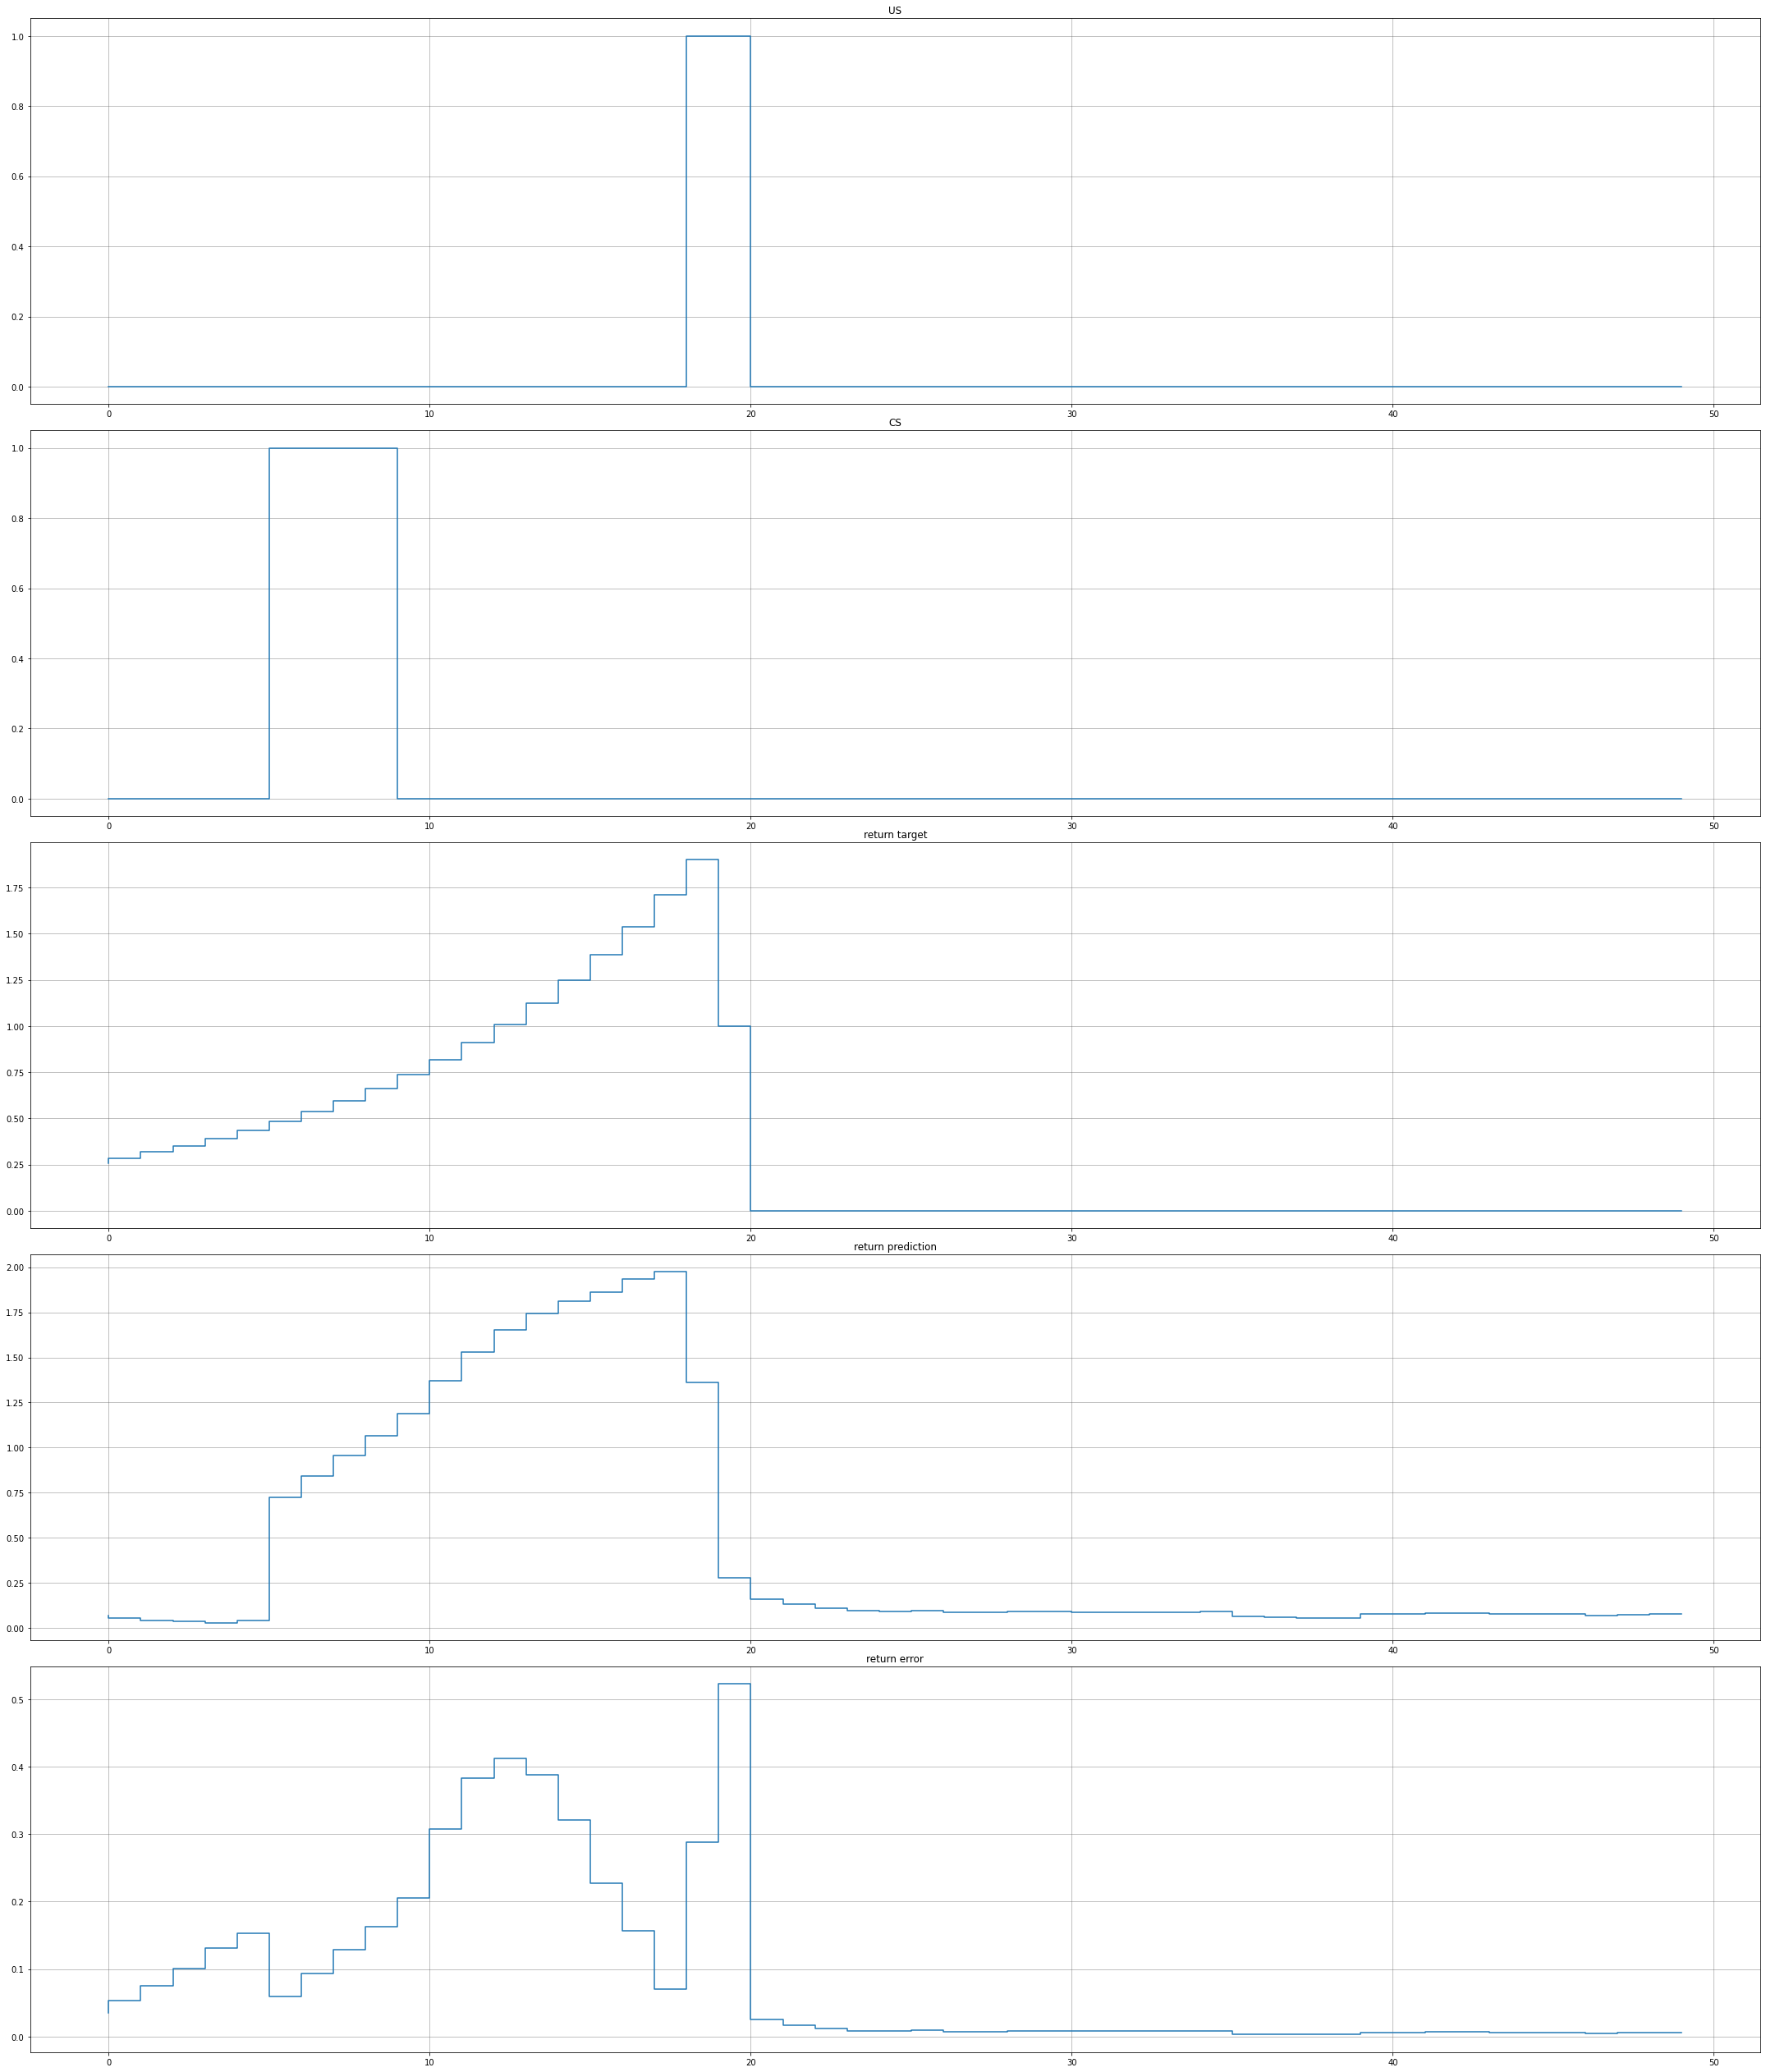

In [47]:
errors = compute_return_error(obsall[:,0], predall, cfg['GAMMA'])
plot_last_n(obsall, predall, errors, n=50)

MSE: 0.2536745821397031


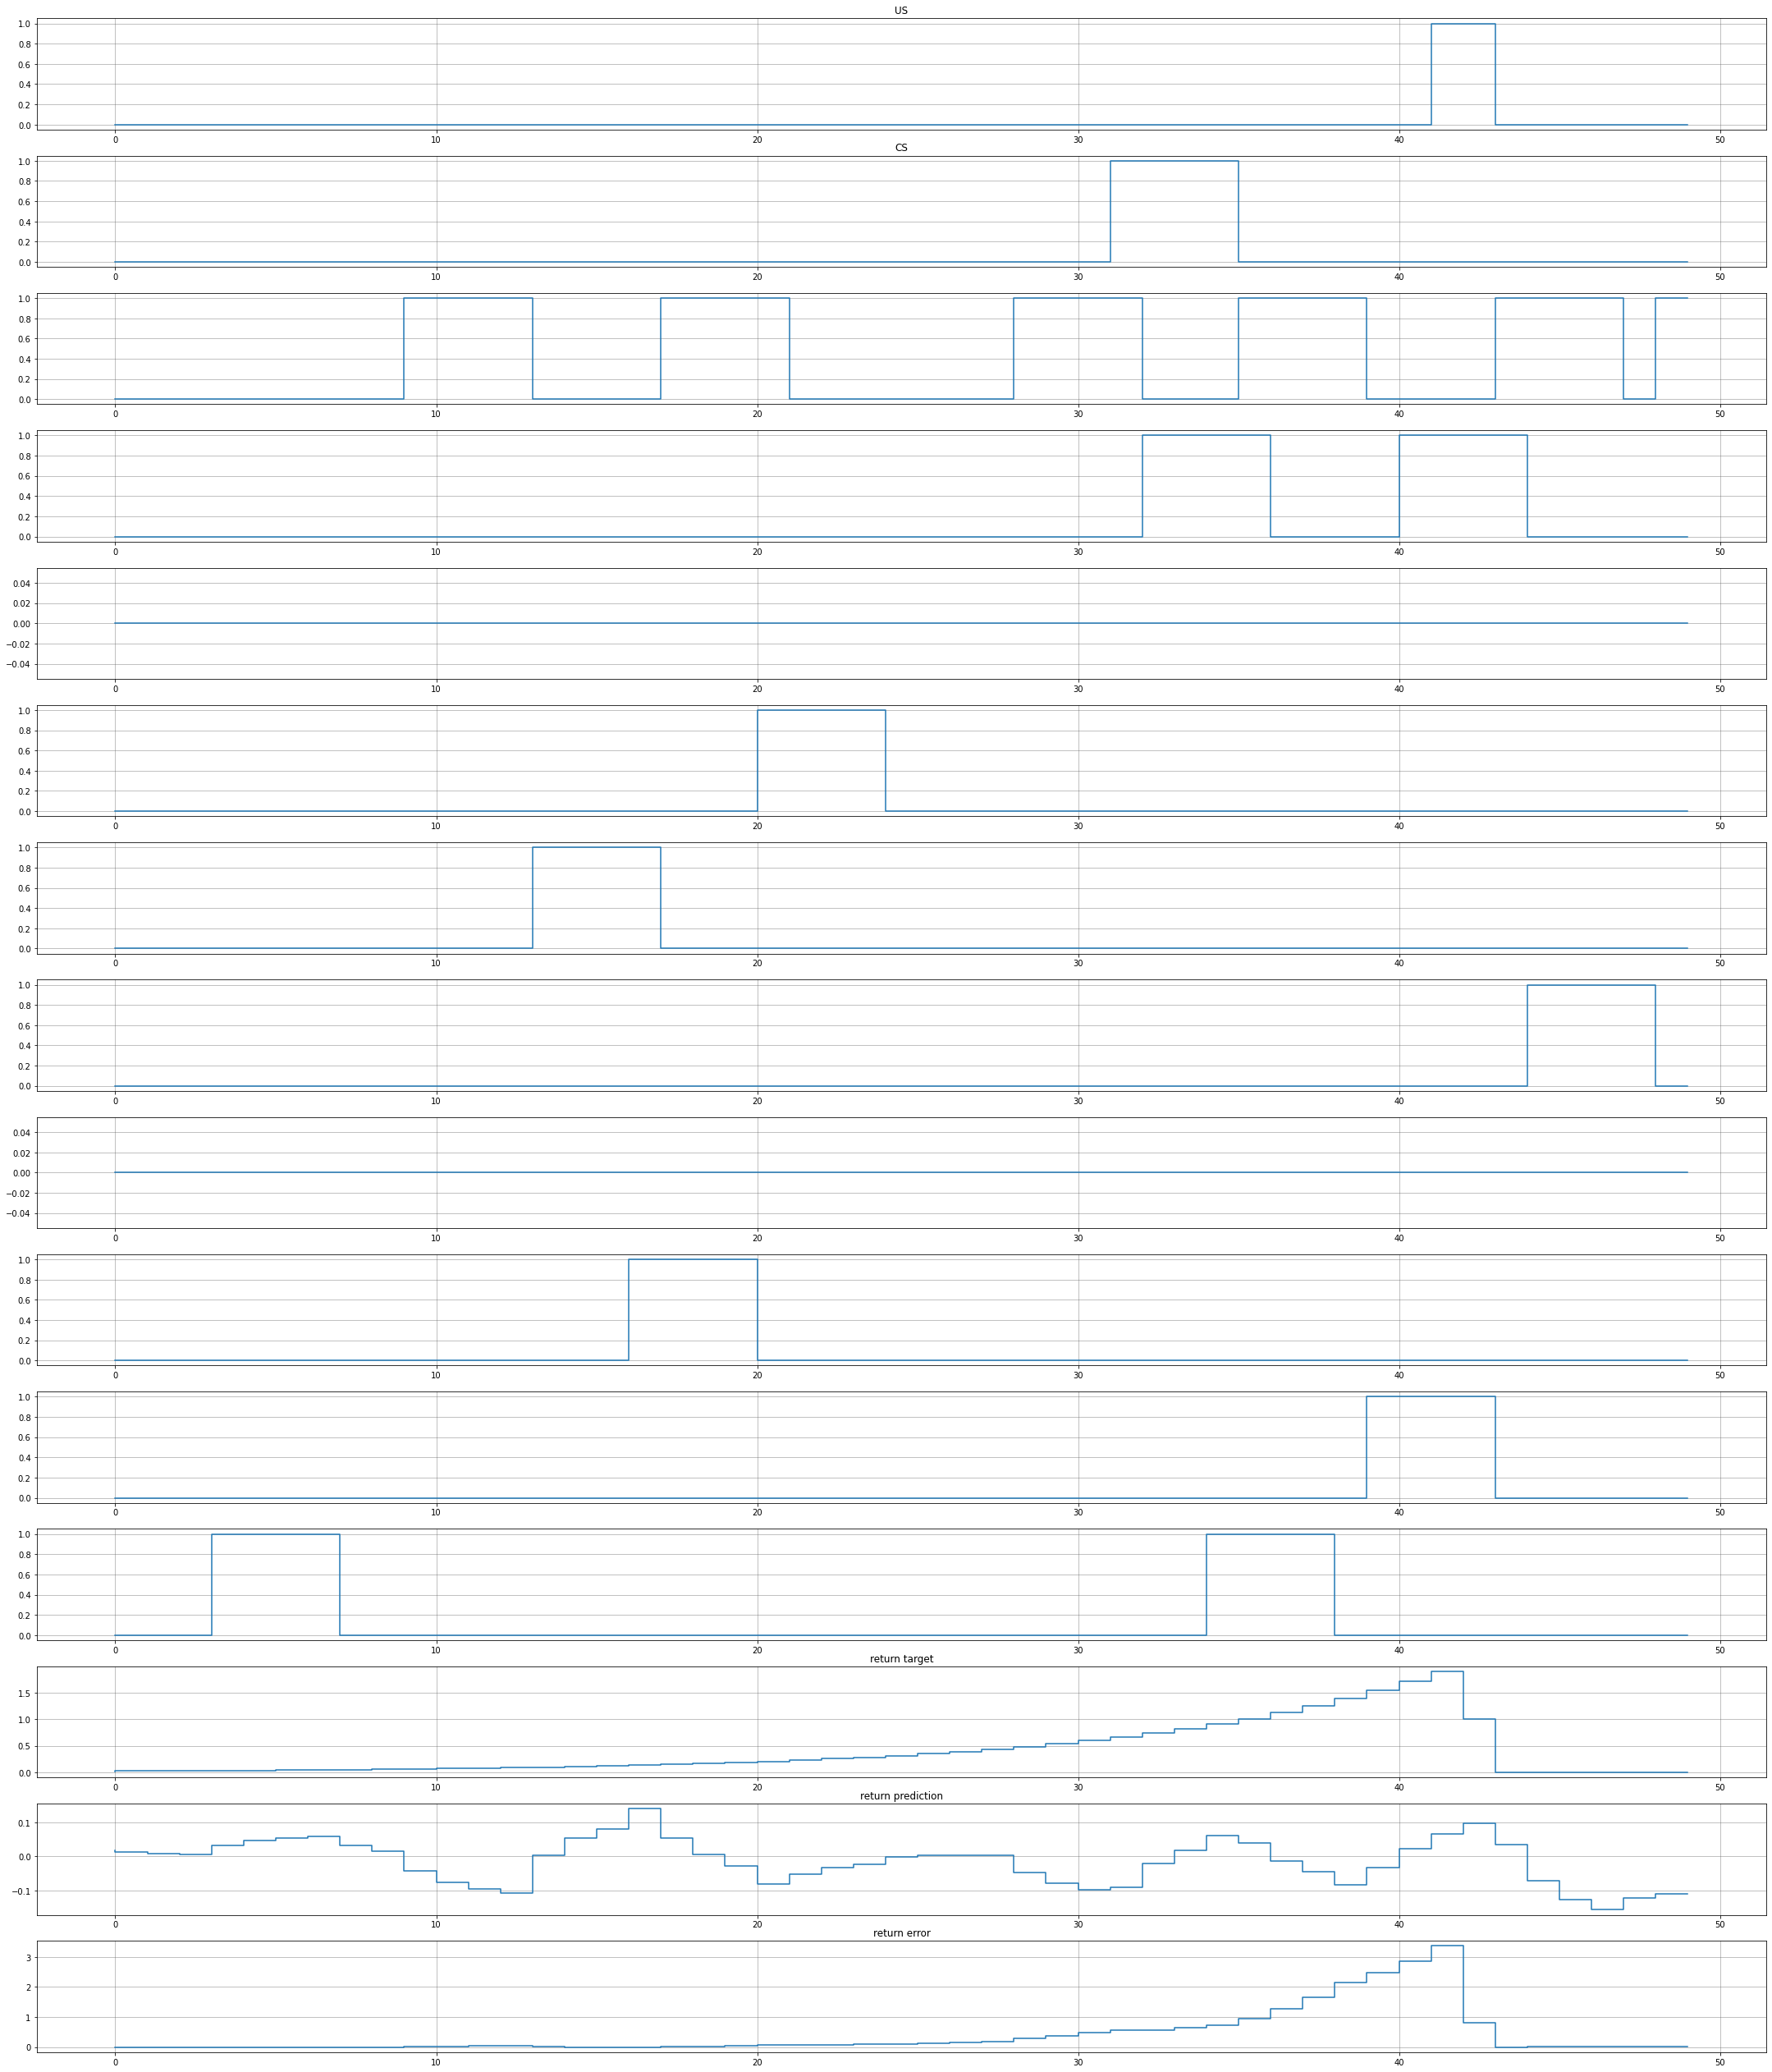

In [23]:
plot_last_n(obsall, predall, errors, n=50)

MSE: 0.06349644023553001


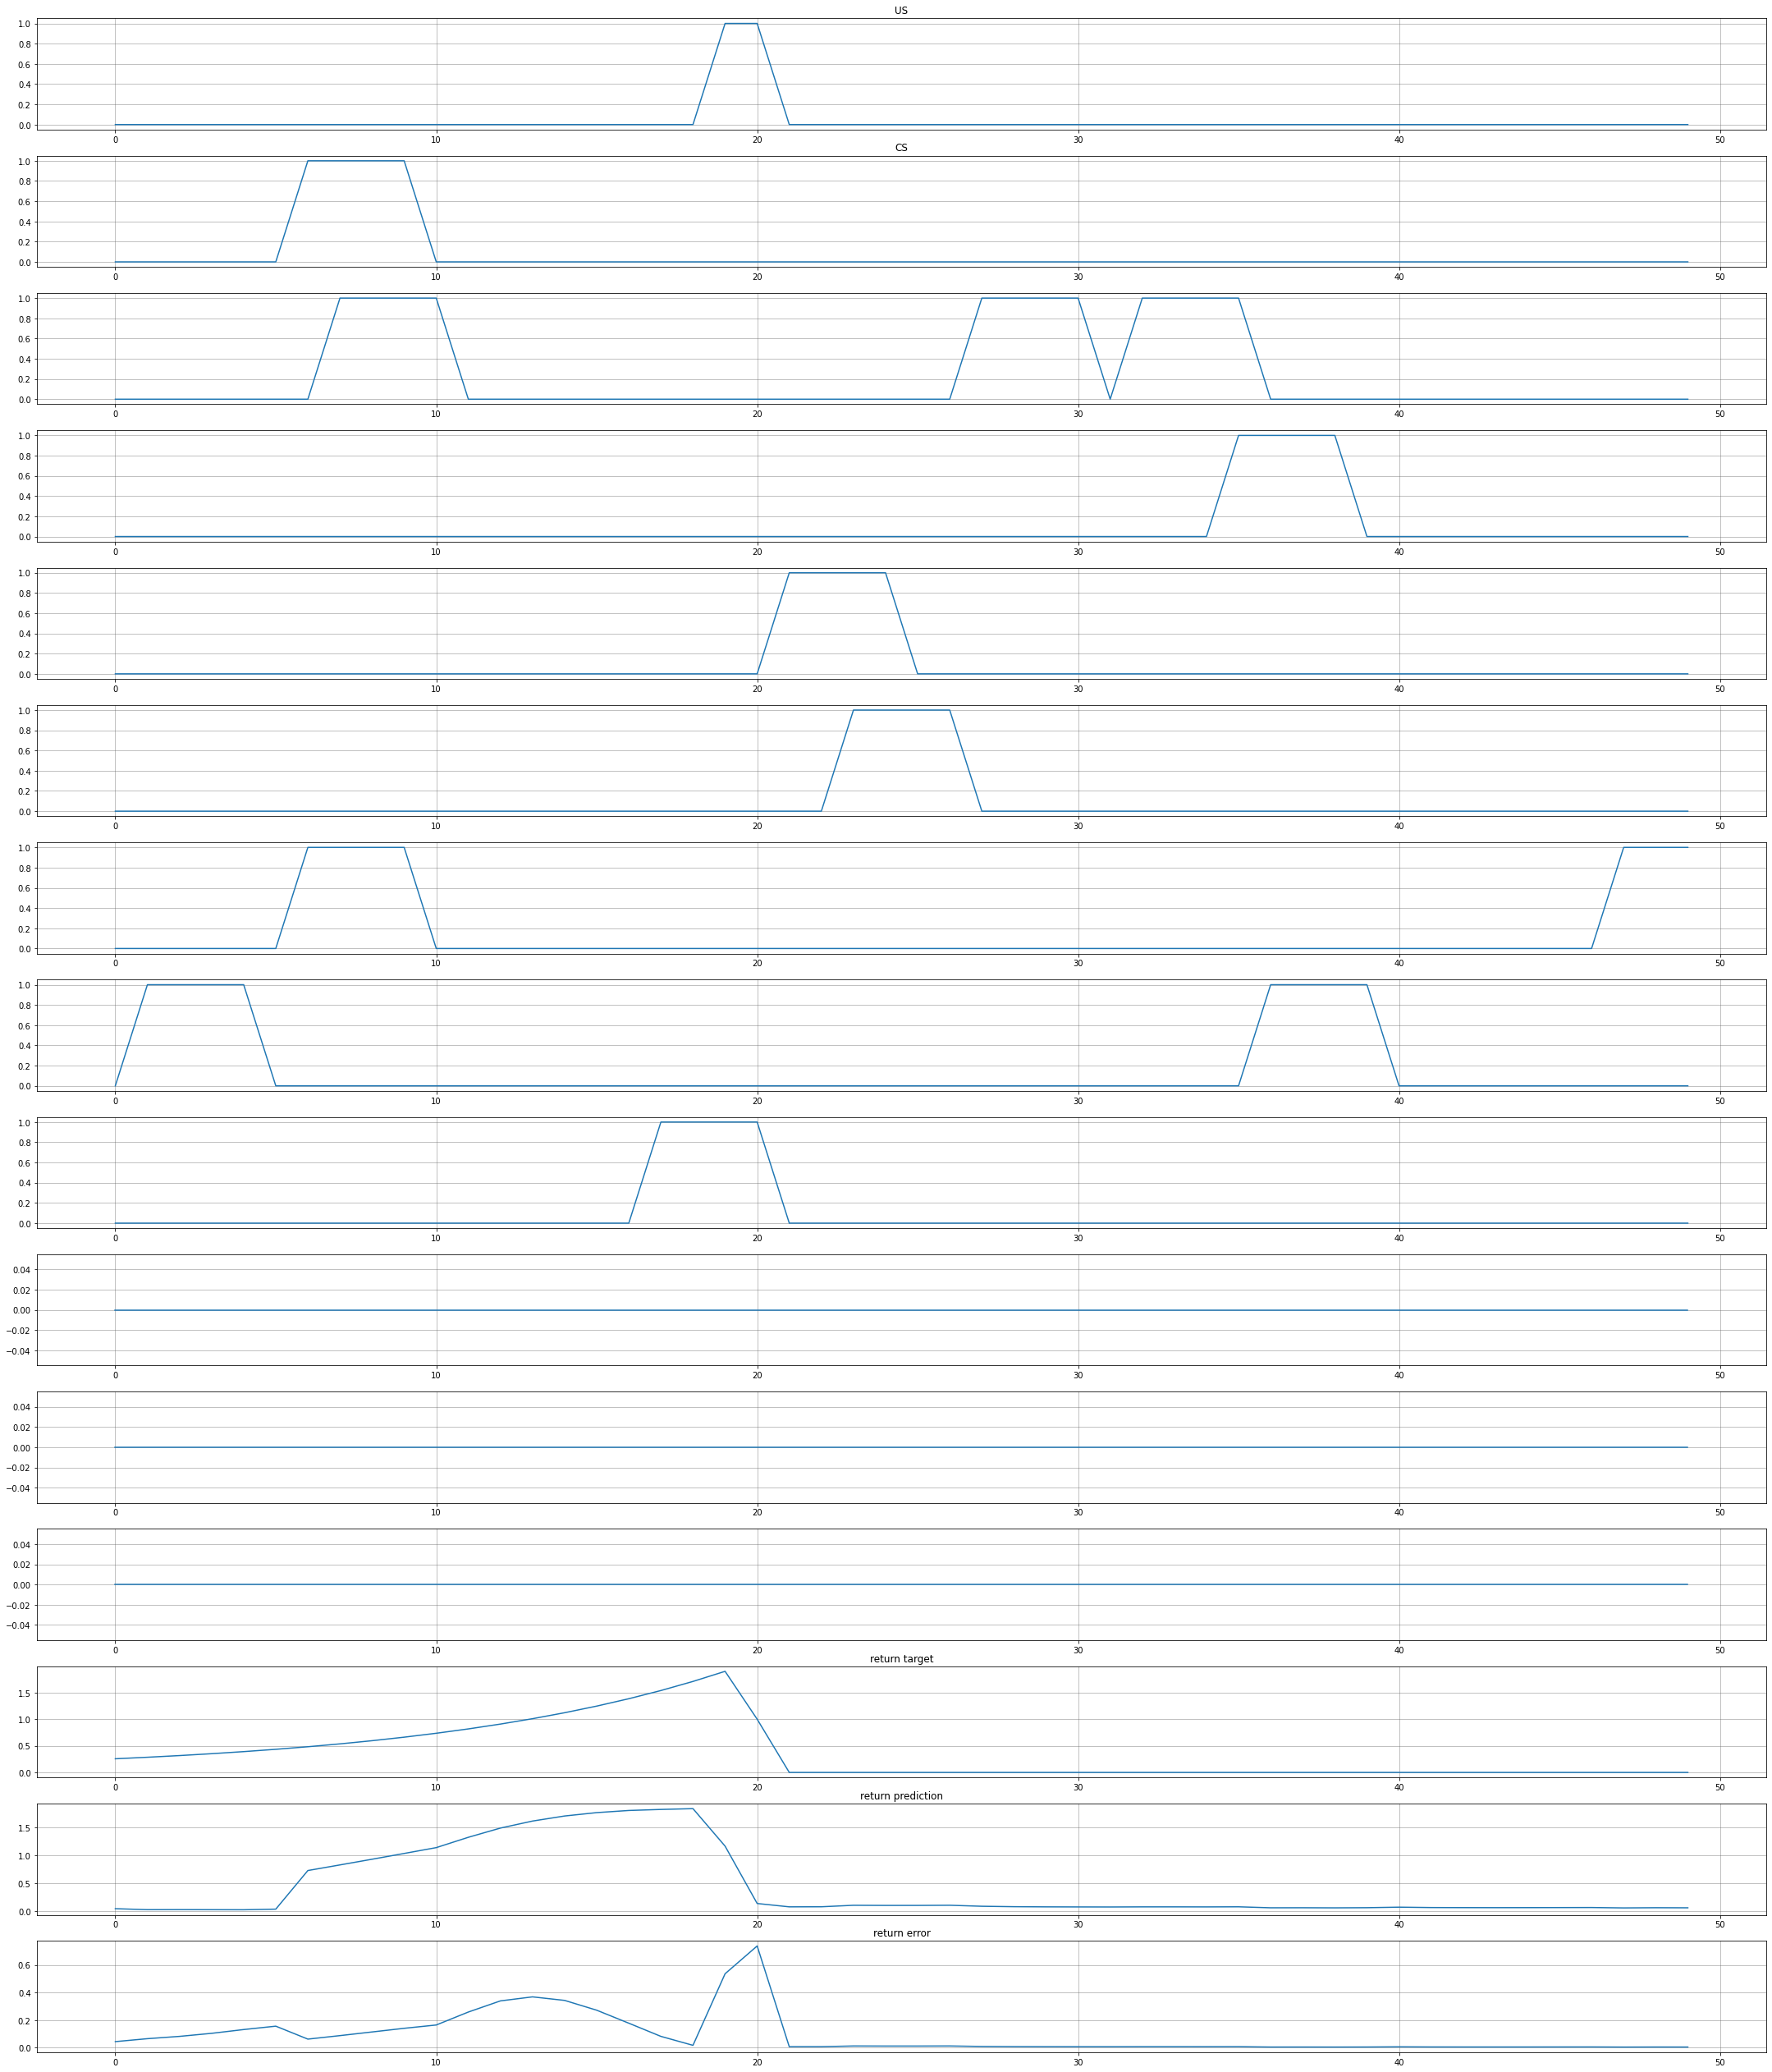

In [25]:
plot_last_n(obsall, predall, errors, n=50)

MSE: 0.04190517299648628


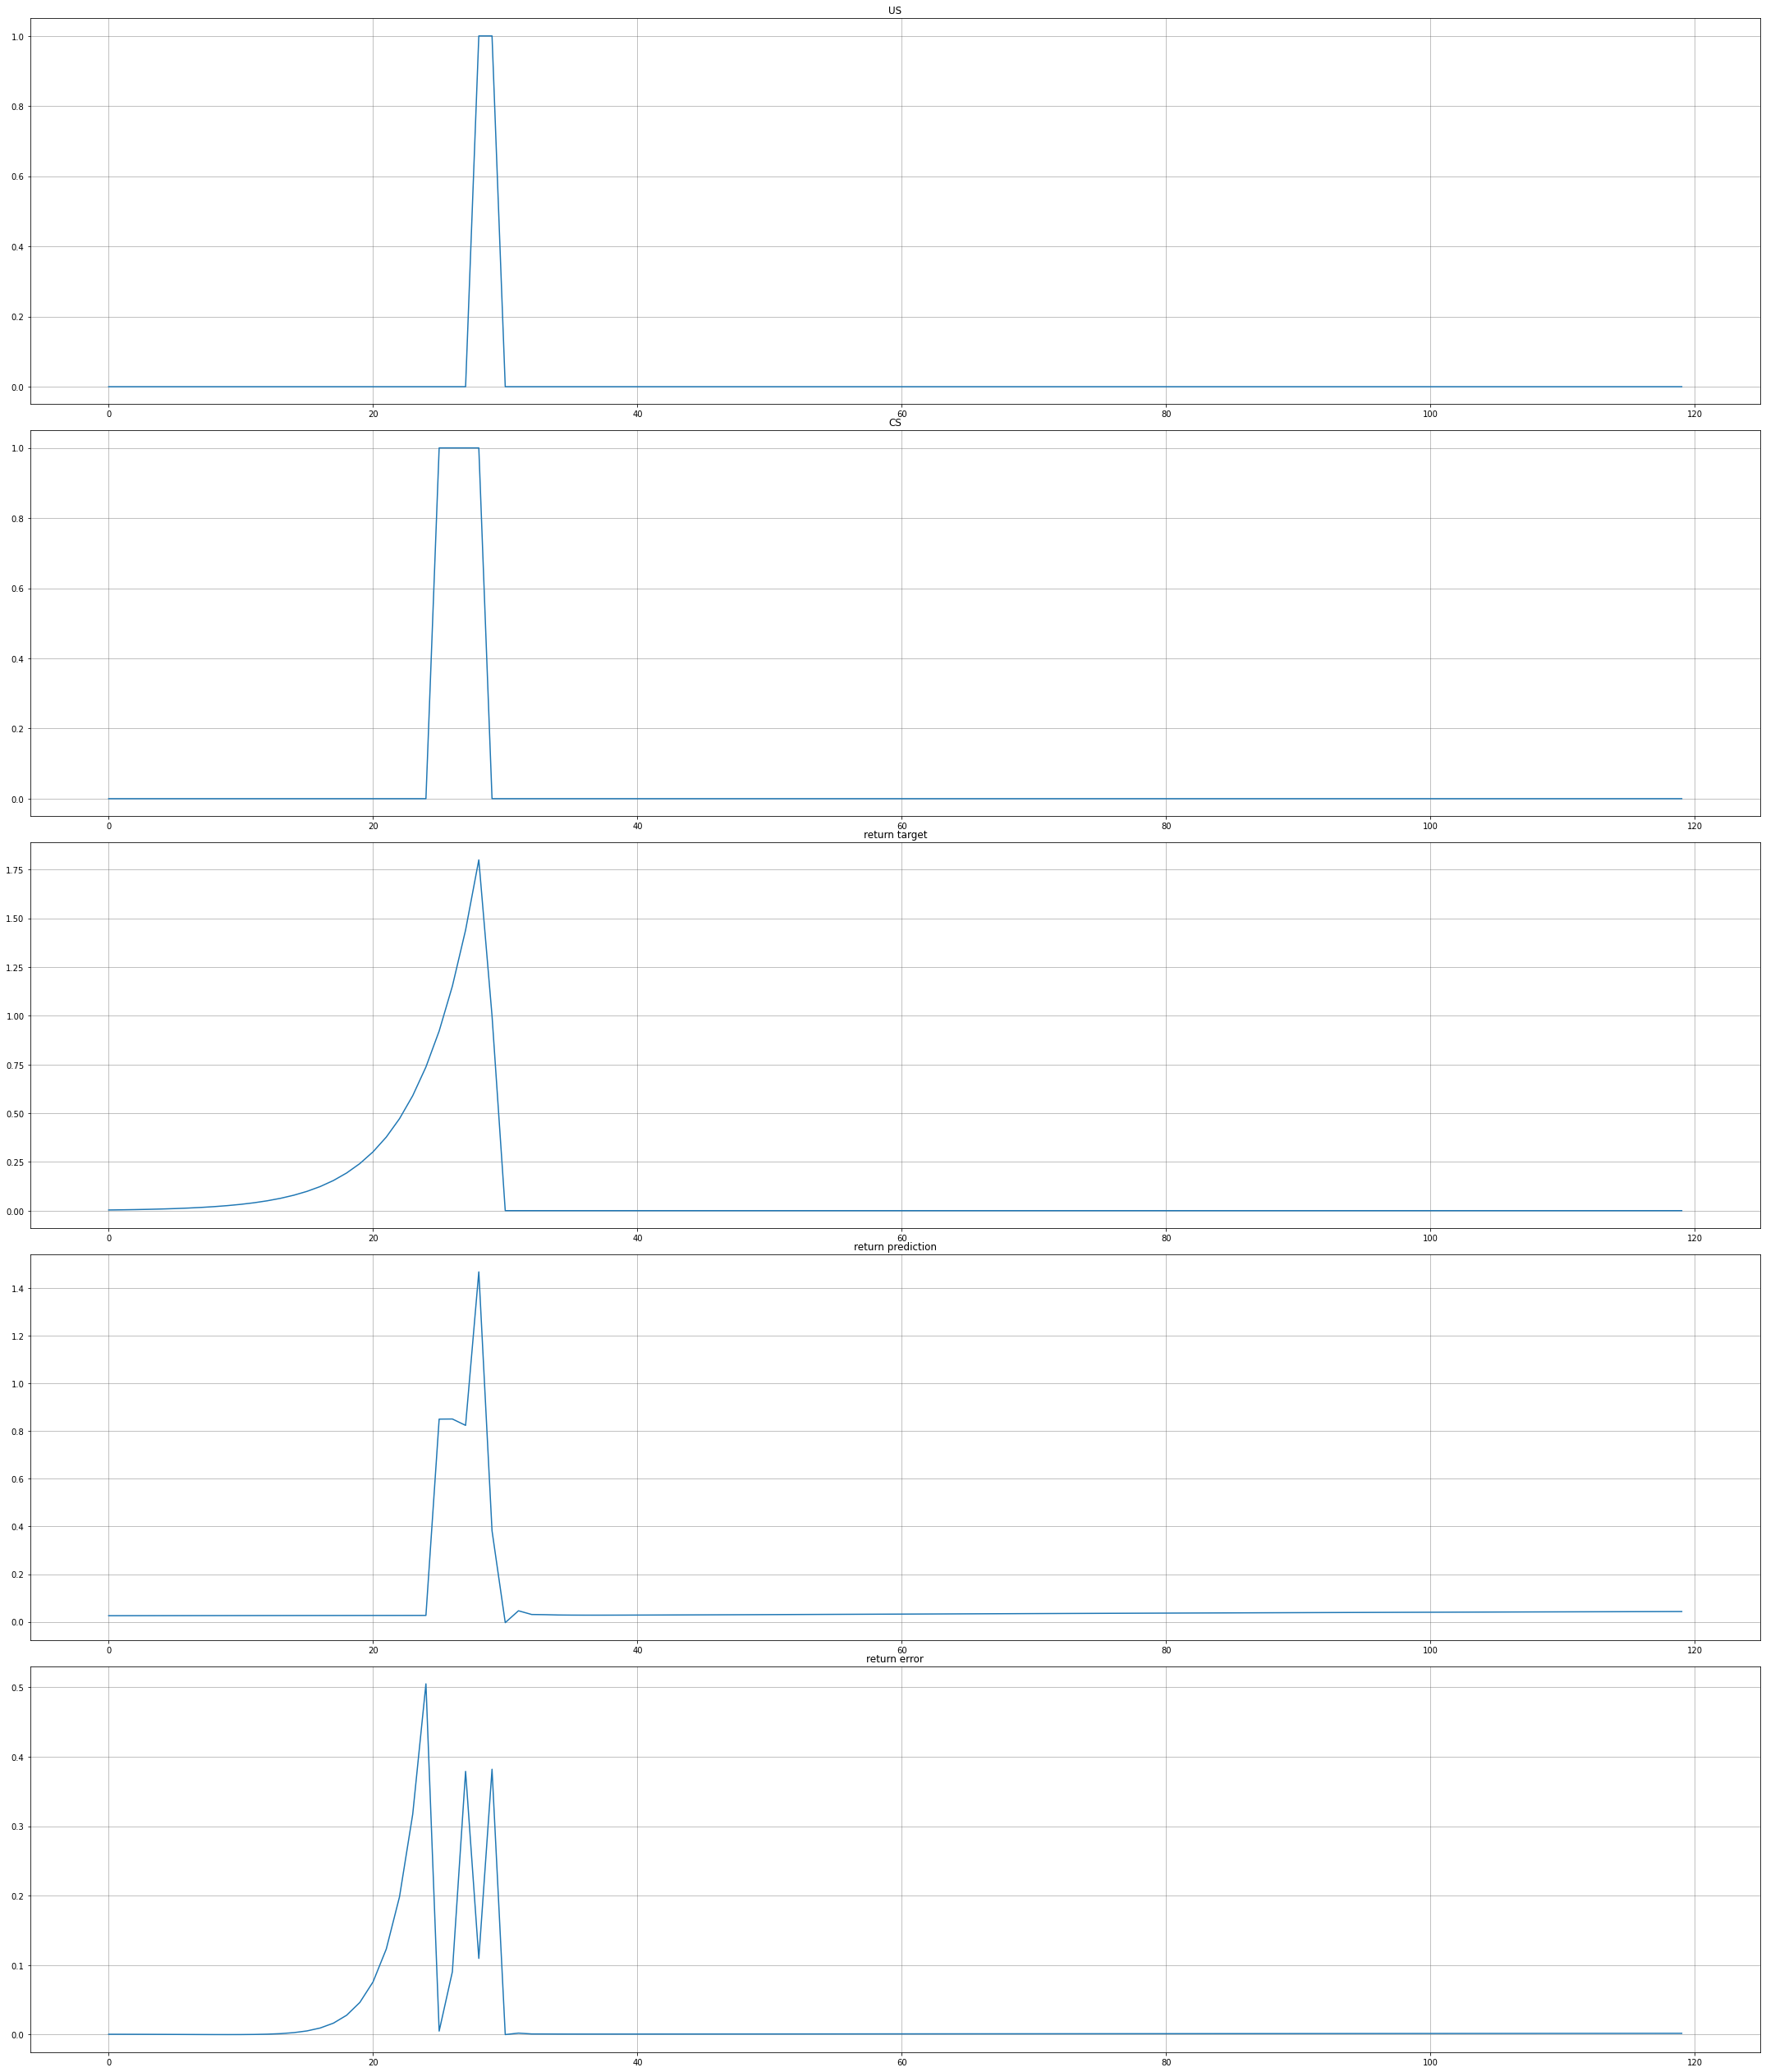

In [11]:
plot_last_n(obsall, predall, errors, n=120)